In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

from warnings import filterwarnings
filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

! pip install -q scikeras
from scikeras.wrappers import KerasRegressor

In [2]:
temp = pd.read_csv('AggregatedData.csv')
temp.head()

,ATM Name,Transaction Date,No Of Withdrawals,No Of XYZ Card Withdrawals,No Of Other Card Withdrawals,Total amount Withdrawn,Amount withdrawn XYZ Card,Amount withdrawn Other Card,Weekday,Festival Religion,Working Day,Holiday Sequence
0,Big Street ATM,1/1/2011,50,20,30,123800,41700,82100,Saturday,H,H,WHH
1,Mount Road ATM,1/1/2011,253,67,186,767900,270900,497000,Saturday,C,H,WHH
2,Airport ATM,1/1/2011,98,56,42,503400,347700,155700,Saturday,C,H,WHH
3,KK Nagar ATM,1/1/2011,265,159,106,945300,532600,412700,Saturday,C,H,WHH
4,Christ College ATM,1/1/2011,74,25,49,287700,148200,139500,Saturday,C,H,WHH


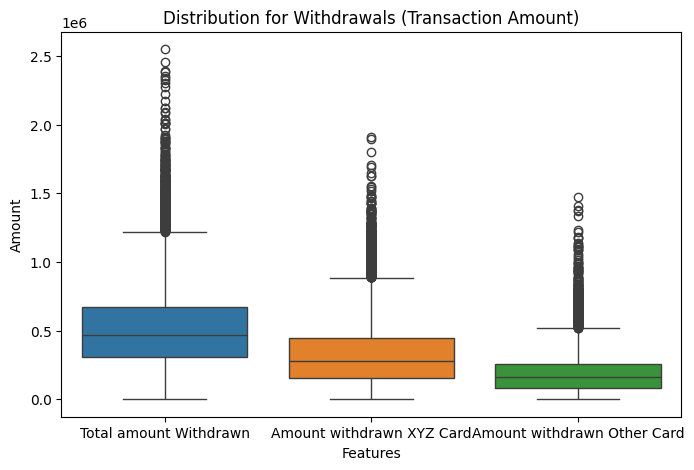

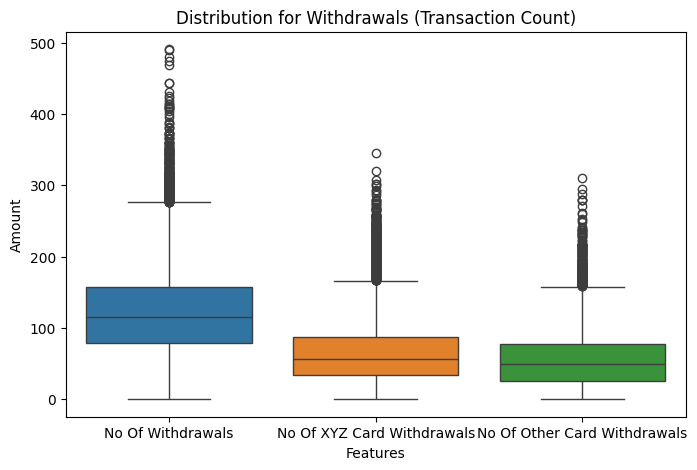

In [3]:
plt.figure(figsize = (8,5))
sns.boxplot(temp[['Total amount Withdrawn', 'Amount withdrawn XYZ Card', 'Amount withdrawn Other Card']])
plt.title('Distribution for Withdrawals (Transaction Amount)')
plt.xlabel('Features')
plt.ylabel('Amount')
plt.show()

print('\n')

plt.figure(figsize = (8,5))
sns.boxplot(temp[['No Of Withdrawals', 'No Of XYZ Card Withdrawals', 'No Of Other Card Withdrawals']])
plt.title('Distribution for Withdrawals (Transaction Count)')
plt.xlabel('Features')
plt.ylabel('Amount')
plt.show()

In [4]:

temp['Transaction Date'] = pd.to_datetime(temp['Transaction Date'], format='mixed')
temp = temp.sort_values(by = ['Transaction Date'])
temp = temp.reset_index(drop = True)


In [5]:
# Removing Outliers

wid = temp['Total amount Withdrawn']
q1 = wid.quantile(0.25)
q3 = wid.quantile(0.75)
iqr = q3 - q1

b = iqr * 1.5 + q3
c1 = temp['Total amount Withdrawn'] < b

wid = temp['Amount withdrawn XYZ Card']
q1 = wid.quantile(0.25)
q3 = wid.quantile(0.75)
iqr = q3 - q1

b = iqr * 1.5 + q3
c2 = temp['Amount withdrawn XYZ Card'] < b

wid = temp['Amount withdrawn Other Card']
q1 = wid.quantile(0.25)
q3 = wid.quantile(0.75)
iqr = q3 - q1

b = iqr * 1.5 + q3
c3 = temp['Amount withdrawn Other Card'] < b

temp = temp.loc[c1 & c2 & c3, :]

In [6]:
def impute(temp, name):

    atm = temp[temp['ATM Name'] == name]

    start = temp['Transaction Date'].min()
    end = temp['Transaction Date'].max()

    dates = pd.date_range(start, end, freq='D')
    bg = pd.DataFrame({'Date': dates})
    new = pd.merge(atm, bg, left_on = 'Transaction Date', right_on = 'Date', how='right')

    ind = new.loc[new['Transaction Date'].isnull(), :].index

    new.loc[ind, 'ATM Name'] = 'Big Street ATM'
    new.loc[ind, 'Transaction Date'] = new.loc[ind, 'Date']
    new['Year Month'] = new['Transaction Date'].apply(lambda x: str(x.year) + '-' + str(x.month))

    monthly_avg = new.groupby('Year Month').agg({'No Of Withdrawals': 'mean', 'Total amount Withdrawn': 'mean',
                                                 'No Of XYZ Card Withdrawals': 'mean', 'Amount withdrawn XYZ Card': 'mean',})
    monthly_avg = np.round(monthly_avg)

    for i in monthly_avg.index.unique():

        c1 = new['Year Month'] == i
        c2 = new['No Of Withdrawals'].isnull()
        c3 = new['Total amount Withdrawn'].isnull()
        new.loc[c1 & c2, 'No Of Withdrawals'] = monthly_avg.loc[i, 'No Of Withdrawals']
        new.loc[c1 & c3, 'Total amount Withdrawn'] = monthly_avg.loc[i, 'Total amount Withdrawn']

        c2 = new['No Of XYZ Card Withdrawals'].isnull()
        c3 = new['Amount withdrawn XYZ Card'].isnull()
        new.loc[c1 & c2, 'No Of XYZ Card Withdrawals'] = monthly_avg.loc[i, 'No Of XYZ Card Withdrawals']
        new.loc[c1 & c3, 'Amount withdrawn XYZ Card'] = monthly_avg.loc[i, 'Amount withdrawn XYZ Card']

    new.loc[ind, 'Holiday Sequence'] = 'NA'
    new.loc[ind, 'Festival Religion'] = 'NA'
    new.loc[ind, 'Working Day'] = 'NA'
    new['Weekday'] = new['Date'].dt.day_name()
    new['Year'] = new['Date'].dt.year
    new['Month'] = new['Date'].dt.month_name()
    new['Weekday'] = new['Weekday'].apply(lambda x: x.capitalize())
    new = new.drop(columns = ['Date', 'Year Month'])

    new = new.sort_values(by = 'Transaction Date')
    return new


In [7]:

temp = temp.drop(columns = [ 'No Of Other Card Withdrawals', 'Amount withdrawn Other Card'])
target = 'Total amount Withdrawn'

dfs = []

for i in sorted(temp['ATM Name'].unique()):
    df = impute(temp, i)
    df.to_csv(f'{i}.csv', index=False)
    dfs.append(df)

temp = pd.concat([dfs[0], dfs[1], dfs[2], dfs[3], dfs[4]], axis = 0)
temp = temp.sort_values(by = ['Transaction Date', 'ATM Name'])

temp = temp.reset_index(drop = True)
temp.to_csv('Indian ATM.csv', index = False)


In [8]:
def transform_split(df, target):

    df = df.drop(columns = ['Transaction Date'])
    X = df.drop(columns = target)
    y = df[target]

    nominal_features = ['ATM Name', "Month", 'Year', "Weekday"]
    ordinal_features = ['Festival Religion', 'Working Day', 'Holiday Sequence']
    numeric_features = [col for col in X.columns if col not in nominal_features + ordinal_features]

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('nom', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), nominal_features),
            ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ordinal_features),
        ], remainder='passthrough')

    pipeline = Pipeline(steps=[('preprocessor', preprocessor)])


    tr = int(len(X) * 0.8)
    ts = int(len(X) * 0.9)
    X_train, y_train = X[:tr], y[:tr]
    X_val, y_val = X[tr:ts], y[tr:ts]
    X_test, y_test = X[ts:], y[ts:]

    X_train = pipeline.fit_transform(X_train)
    X_val = pipeline.transform(X_val)
    X_test = pipeline.transform(X_test)

    return X_train, X_val, X_test, y_train, y_val, y_test


In [9]:
df = temp.copy()

# preprocessing and splitting data
X_train, X_val, X_test, y_train, y_val, y_test = transform_split(df, 'Total amount Withdrawn')

X = np.vstack([X_train, X_val, X_test])
y = np.hstack([y_train, y_val, y_test])


preprocessed_data = np.hstack([X, y.reshape(-1, 1)])
preprocessed_data = pd.DataFrame(preprocessed_data)
preprocessed_data.to_csv('Indian ATM preprocessed.csv', index=False)